In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from statistics import mean
import os
from sklearn.metrics.pairwise import euclidean_distances
import math

## Code

In [2]:
def read_barcodes(barcodes_file):
    barcodes = pd.read_csv(barcodes_file, sep = '\t',header = None)
    barcodes.columns = ['barcode']
    barcodes.index += 1
    barcodes['barcode_id'] = barcodes.index
    return barcodes

def read_features(features_file):
    features = pd.read_csv(features_file, sep = '\t',header = None)
    features.index += 1
    features.columns = ['feature_code','value','type']
    features['feature_id'] = features.index
    features['feature_id'] = pd.to_numeric(features['feature_id'])
    return features

def read_matrix(matrix_file):
    matrix = pd.read_csv(matrix_file,sep = '\t')
    matrix = matrix.drop([0])
    matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
    matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
    matrix = matrix.apply(pd.to_numeric)
    matrix['count']=matrix['count'].astype(int)
    return matrix

def merge_matrix(matrix,barcodes,features):
    matrix = pd.merge(matrix, barcodes, on="barcode_id")
    matrix = pd.merge(matrix, features, on="feature_id")
    #matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
    return matrix


def get_value_matrix(matrix):
    v_t = matrix['value'].str.split('_',n=1,expand=True)
    matrix['value']=v_t[0]
    matrix['value_type']=v_t[1]
    return matrix

## we dont use it here
def get_tetramer_matrix(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    #tetramers = tetramers[tetramers['count']>5]
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode_id','tetramer']]
    matrix = pd.merge(matrix, tetramers, on="barcode_id")
    return matrix[['barcode','value','tetramer','count']]

def get_barcode_tetramer(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode','tetramer']]
    return tetramers

In [3]:
def prep_annot_data(data):
    data_c = data[data['is_cell']==True].reset_index(drop=True)
    data_c = data_c[data_c['chain'] == "TRB"]
    
    data_c = data_c[-data_c['v_gene'].isna()]
    data_c = data_c[-data_c['j_gene'].isna()]
    
    data_c = data_c[-data_c['cdr3'].isna()]
    #data_no_10x = data_no_10x[-data_no_10x['antigen.epitope'].isna()]
    data_c = data_c[-data_c['v_gene'].str.contains(',')]
    data_c = data_c[-data_c['j_gene'].str.contains(',')]
    data_c = data_c[-data_c['cdr3'].str.contains('\*')]
    data_c = data_c[data_c['cdr3']!='None']
    return data_c

def merge_anot_matrix(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    #data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    #data_c = data_c[data_c['cdr3']!='None']
    return data_c

In [4]:
def pivot_data(data):
    data = data[['count','barcode','value']]
    data = data.pivot_table('count','barcode','value')
    data = data.fillna(0)
    return data

In [5]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

In [6]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

### Table prep for MIR

In [7]:
def aminoacid_to_nt(cdr3):
    gene_code = {"A":"GCT", "C":"TGT", "T":"ACT", "S":"TCT", "F": "TTT", "L":"TTA", "I":"ATT", 
                 "M":"ATG", "V":"GTT", "P":"CCT", "Y":"TAT", "H":"CAT","Q": "CAA", "N":"AAT", 
                 "K":"AAA", "D":"GAT", "E":"GAA", "W":"TGG", "R":"CGT", "G":"GGT"}
    res = ''.join([gene_code.get(i) for i in list(cdr3)])
    return res

def filter_table(data,chain):
    if chain== "TRA":
        data = data[data['chain'] == "TRA"]
    
    if chain== "TRB":
        data = data[data['chain'] == "TRB"]
    #cols_input = list(data.columns)
    data = data[-data['v_gene'].isna()]
    data = data[-data['j_gene'].isna()]
    data = data[-(data['v_gene']== "None")]
    data = data[-(data['j_gene']== "None")]
    data = data[-(data['j_gene']== "")]
    data = data[-(data['v_gene']== "")]
    data = data[-data['v_gene'].str.contains(',')]
    data = data[-data['j_gene'].str.contains(',')]

    data = data[-(data['cdr3']== "")]
    data = data[-(data['cdr3']== "None")]
    data = data[-data['cdr3'].isna()]
    data = data[-data['cdr3'].str.contains('\.')]
    data = data[-data['cdr3'].str.contains('\*')]
    
    data = data[data['high_confidence']==True]
    data = data.reset_index(drop=True)
    return data
    
def columns_prep(data):

    data = data.assign(d_gene = ".")
    data = data.assign(count = 1)
    data['DStart'] =  -1
    data['DEnd'] =  -1
    data['VEnd'] =  -1
    data['JStart'] =  -1
    data['freq'] =  -1
    data['cdr3nt'] = data['cdr3'].apply(lambda x: aminoacid_to_nt(x))
    
    data = data.rename(columns={"cdr3": "cdr3aa"})
    data = data.rename(columns={"v_gene": "v"})
    data = data.rename(columns={"j_gene": "j"})
    data = data.assign(subset = ".")
    #data = data.rename(columns={"value": "subset"})
    #data = data.rename(columns={"cdr3_nt": "cdr3nt"})

    cols = ["count", "freq", "cdr3aa", "cdr3nt", "v", "d", "j", "VEnd", "DStart", "DEnd","JStart","contig_id","reads","umis","length","subset"]
    data.drop(set(data.columns) - set(cols), axis=1, inplace=True)
    return data

In [8]:
def table_prep(data,chain):
    if chain== "TRA":
        data = data[data['chain'] == "TRA"]
    
    if chain== "TRB":
        data = data[data['chain'] == "TRB"]
    
    data = data[-data['v_gene'].isna()]
    data = data[-data['j_gene'].isna()]
    data = data[-(data['v_gene']== "None")]
    data = data[-(data['j_gene']== "None")]
    data = data[-(data['j_gene']== "")]
    data = data[-(data['v_gene']== "")]
    data = data[-data['v_gene'].str.contains(',')]
    data = data[-data['j_gene'].str.contains(',')]

    data = data[-(data['cdr3']== "")]
    data = data[-(data['cdr3']== "None")]
    data = data[-data['cdr3'].isna()]
    data = data[-data['cdr3'].str.contains('\.')]
    data = data[-data['cdr3'].str.contains('\*')]

    data = data.assign(d_gene = ".")
    data = data.assign(count = 1)
    data['DStart'] =  -1
    data['DEnd'] =  -1
    data['VEnd'] =  -1
    data['JStart'] =  -1
    data['freq'] =  -1
    data['cdr3nt'] = data['cdr3'].apply(lambda x: aminoacid_to_nt(x))
    
    data = data.rename(columns={"cdr3": "cdr3aa"})
    data = data.rename(columns={"v_gene": "v"})
    data = data.rename(columns={"j_gene": "j"})
    data = data.assign(subset = ".")
    #data = data.rename(columns={"value": "subset"})
    #data = data.rename(columns={"cdr3_nt": "cdr3nt"})

    cols = ["count", "freq", "cdr3aa", "cdr3nt", "v", "d", "j", "VEnd", "DStart", "DEnd","JStart","contig_id","reads","umis","length","subset"]
    data.drop(set(data.columns) - set(cols), axis=1, inplace=True)
    data = data.drop_duplicates(subset = ['cdr3aa'], keep = False)
    data = data.reset_index(drop=True)
    return data

## Reading and processing raw data

In [9]:
barcodes = read_barcodes('data/filtered_feature_bc_matrix/barcodes.tsv')
features = read_features('data/filtered_feature_bc_matrix/features.tsv')
matrix = read_matrix('data/filtered_feature_bc_matrix/matrix.mtx')
matrix = merge_matrix(matrix,barcodes,features)
matrix = get_value_matrix(matrix)

matrix = matrix[matrix['type']=='Antibody Capture']
matrix = matrix[matrix['value_type']!='TotalSeqC']
barcode_tetramer = get_barcode_tetramer(matrix)


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
barcode_tetramer = get_barcode_tetramer(matrix)
barcode_tetramer

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,barcode,tetramer
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL
38209278,AACCGCGCATCCGGGT-36,IVTDFSVIK
38240451,CGTTGGGGTAAGTAGT-36,AVFDRKSDAK
38240788,GTGAAGGCAACCGCCA-36,AVFDRKSDAK
38240930,TCGTAGAAGTCCGGTC-36,AVFDRKSDAK
...,...,...
17062251,CCTTTCTGTTGCCTCT-34,KLGGALQAK
61364026,TGACAACGTTCGGCAC-8,KVAELVHFL
17062217,CCGGGATCACGGTTTA-34,KLGGALQAK
61363854,TGTGTTTTCCCAACGG-6,KVAELVHFL


In [11]:
data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')

In [12]:
data_work = data.copy()
data_work = data_work[data_work['is_cell']==True].reset_index(drop=True)
data_work = filter_table(data_work,'TRB')
data_work

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48547,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2
48548,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1
48549,TTTGTCATCTCGAGTA-40,True,TTTGTCATCTCGAGTA-40_contig_1,True,716,TRB,TRBV9,TRBD1,TRBJ2-1,TRBC2,True,True,CASSLWTGDNEQFF,TGTGCCAGCAGCCTCTGGACAGGGGACAATGAGCAGTTCTTC,2787,4,clonotype30339,clonotype30339_consensus_1
48550,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2


In [13]:
data_work = data_work.drop_duplicates(subset = ['barcode'], keep = False)
data_work

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48547,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2
48548,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1
48549,TTTGTCATCTCGAGTA-40,True,TTTGTCATCTCGAGTA-40_contig_1,True,716,TRB,TRBV9,TRBD1,TRBJ2-1,TRBC2,True,True,CASSLWTGDNEQFF,TGTGCCAGCAGCCTCTGGACAGGGGACAATGAGCAGTTCTTC,2787,4,clonotype30339,clonotype30339_consensus_1
48550,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2


In [25]:
data_work.drop_duplicates(subset = ['barcode','cdr3'], keep = False)

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48547,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2
48548,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1
48549,TTTGTCATCTCGAGTA-40,True,TTTGTCATCTCGAGTA-40_contig_1,True,716,TRB,TRBV9,TRBD1,TRBJ2-1,TRBC2,True,True,CASSLWTGDNEQFF,TGTGCCAGCAGCCTCTGGACAGGGGACAATGAGCAGTTCTTC,2787,4,clonotype30339,clonotype30339_consensus_1
48550,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2


In [26]:
data_work.drop_duplicates(subset = ['cdr3'], keep = False)

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2
6,AAACCTGAGATCCTGT-25,True,AAACCTGAGATCCTGT-25_contig_1,True,518,TRB,TRBV3-1,TRBD2,TRBJ2-1,TRBC2,True,True,CASAVGLTYNEQFF,TGTGCCAGCGCGGTGGGACTTACGTACAATGAGCAGTTCTTC,5456,3,clonotype1322,clonotype1322_consensus_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48545,TTTGTCATCGAGCCCA-39,True,TTTGTCATCGAGCCCA-39_contig_1,True,686,TRB,TRBV7-9,None,TRBJ1-2,TRBC1,True,True,CASSLGGEKTF,TGTGCCAGCAGCTTAGGCGGCGAGAAGACCTTC,15744,13,clonotype30335,clonotype30335_consensus_2
48547,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2
48548,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1
48549,TTTGTCATCTCGAGTA-40,True,TTTGTCATCTCGAGTA-40_contig_1,True,716,TRB,TRBV9,TRBD1,TRBJ2-1,TRBC2,True,True,CASSLWTGDNEQFF,TGTGCCAGCAGCCTCTGGACAGGGGACAATGAGCAGTTCTTC,2787,4,clonotype30339,clonotype30339_consensus_1


In [28]:
data_work = merge_anot_matrix(data_work,barcode_tetramer)
data_work

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1,RAKFKQLL
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2,RLRAEAQVK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40369,TTTGTCATCGAGGTAG-13,True,TTTGTCATCGAGGTAG-13_contig_3,True,679,TRB,TRBV19,None,TRBJ1-5,TRBC1,True,True,CASSTSNEQPQHF,TGTGCCAGTAGTACGTCGAATGAACAGCCCCAGCATTTT,2415,2,clonotype30336,clonotype30336_consensus_2,GILGFVFTL
40370,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2,IVTDFSVIK
40371,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1,AVFDRKSDAK
40372,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2,KLGGALQAK


In [29]:
data_work = data_work.drop_duplicates(subset = ['cdr3'], keep = False)

In [30]:
#data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot = prep_annot_data(data)
data_c = data_c_annot.copy()
data_c = merge_anot_matrix(data_c,barcode_tetramer)
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1,AVFDRKSDAK
1,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_4,False,468,TRB,None,None,TRBJ2-3,TRBC2,False,None,None,None,2517,1,clonotype19,None,AVFDRKSDAK
2,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_5,False,488,TRB,None,None,TRBJ2-6,TRBC2,False,None,None,None,2468,1,clonotype19,None,AVFDRKSDAK
3,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_6,False,359,TRB,None,None,TRBJ2-4,TRBC2,False,None,None,None,1451,1,clonotype19,None,AVFDRKSDAK
4,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1,AVFDRKSDAK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84302,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_1,True,428,TRB,None,None,TRBJ2-4,TRBC2,False,None,None,None,3140,2,clonotype30338,None,AVFDRKSDAK
84303,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1,AVFDRKSDAK
84304,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2,KLGGALQAK
84305,TTTGTCATCTGTCCGT-39,True,TTTGTCATCTGTCCGT-39_contig_1,True,955,TRB,TRBV23-1,TRBD2,TRBJ1-1,TRBC1,True,True,CISAPAVPPAGKAFF,TGTATCTCTGCGCCAGCAGTTCCCCCGGCCGGGAAAGCTTTCTTT,3915,4,clonotype30340,clonotype30340_consensus_2,GLCTLVAML


In [31]:
data_c = filter_table(data_work,'TRB')
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer
0,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1,AVFDRKSDAK
1,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1,CLLGTYTQDV
2,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1,RAKFKQLL
3,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2,RLRAEAQVK
4,AAACCTGAGATCCTGT-25,True,AAACCTGAGATCCTGT-25_contig_1,True,518,TRB,TRBV3-1,TRBD2,TRBJ2-1,TRBC2,True,True,CASAVGLTYNEQFF,TGTGCCAGCGCGGTGGGACTTACGTACAATGAGCAGTTCTTC,5456,3,clonotype1322,clonotype1322_consensus_1,TPRVTGGGAM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,TTTGTCATCGAGCCCA-39,True,TTTGTCATCGAGCCCA-39_contig_1,True,686,TRB,TRBV7-9,None,TRBJ1-2,TRBC1,True,True,CASSLGGEKTF,TGTGCCAGCAGCTTAGGCGGCGAGAAGACCTTC,15744,13,clonotype30335,clonotype30335_consensus_2,AVFDRKSDAK
21573,TTTGTCATCGAGGTAG-13,True,TTTGTCATCGAGGTAG-13_contig_3,True,679,TRB,TRBV19,None,TRBJ1-5,TRBC1,True,True,CASSTSNEQPQHF,TGTGCCAGTAGTACGTCGAATGAACAGCCCCAGCATTTT,2415,2,clonotype30336,clonotype30336_consensus_2,GILGFVFTL
21574,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2,IVTDFSVIK
21575,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1,AVFDRKSDAK


In [93]:
data_c_mir = columns_prep(data_c)


In [94]:
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
1,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
2,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
3,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
4,AAACCTGAGATCCTGT-25_contig_1,518,TRBV3-1,TRBJ2-1,CASAVGLTYNEQFF,5456,3,1,-1,-1,-1,-1,-1,TGTGCTTCTGCTGTTGGTTTAACTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,TTTGTCATCGAGCCCA-39_contig_1,686,TRBV7-9,TRBJ1-2,CASSLGGEKTF,15744,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGGTGAAAAAACTTTT,.
21573,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
21574,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
21575,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [95]:
#temp file
file_date = '080522'
file_path = 'data/10x_trb_' + file_date +'.txt'
data_c_mir.to_csv(file_path, sep='\t', index = False)

In [96]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "/home/yuliajk/projects/tcr_emb_2022/data/prototypes_280322.txt"
input_data_path = 'data/10x_trb_' + file_date +'.txt'
output_path = "data_scripts/10x_trb_" + file_date + "_"

#command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
#os.system(command)




In [97]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

0

In [98]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_mir = pd.read_csv(input_data_path, sep='\t')
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
1,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
2,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
3,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
4,AAACCTGAGATCCTGT-25_contig_1,518,TRBV3-1,TRBJ2-1,CASAVGLTYNEQFF,5456,3,1,-1,-1,-1,-1,-1,TGTGCTTCTGCTGTTGGTTTAACTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,TTTGTCATCGAGCCCA-39_contig_1,686,TRBV7-9,TRBJ1-2,CASSLGGEKTF,15744,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGGTGAAAAAACTTTT,.
21573,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
21574,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
21575,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [99]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,124.0,54.0,15.0
1,1,2,107.0,65.0,33.0
2,1,3,107.0,54.0,24.0
3,1,4,96.0,54.0,23.0
4,1,5,96.0,54.0,14.0
...,...,...,...,...,...
6473095,300,21573,137.0,42.0,19.0
6473096,300,21574,265.0,56.0,33.0
6473097,300,21575,147.0,45.0,9.0
6473098,300,21576,127.0,46.0,18.0


In [100]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id1"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id1"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id1"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id2',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id2',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id2',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id2',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c['barcode'],drop = True)

In [97]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id1',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id1',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c_mir['cdr3aa'],drop = True)

ValueError: Length mismatch: Expected 300 rows, received array of length 40374

In [66]:
data_c_b_dist

,cdr3_1,cdr3_10,cdr3_100,cdr3_101,cdr3_102,cdr3_103,cdr3_104,cdr3_105,cdr3_106,cdr3_107,...,j_90,j_91,j_92,j_93,j_94,j_95,j_96,j_97,j_98,j_99
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACTGTAA-34,15.0,10.0,22.0,13.0,26.0,8.0,13.0,11.0,20.0,19.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0
AAACCTGAGAGCCCAA-5,33.0,21.0,18.0,23.0,17.0,15.0,33.0,37.0,13.0,17.0,...,41.0,65.0,41.0,84.0,41.0,39.0,65.0,84.0,60.0,49.0
AAACCTGAGAGCTGCA-24,24.0,17.0,22.0,24.0,23.0,17.0,26.0,28.0,18.0,22.0,...,43.0,54.0,43.0,60.0,43.0,35.0,54.0,60.0,81.0,42.0
AAACCTGAGAGGGATA-8,23.0,13.0,15.0,27.0,36.0,18.0,23.0,19.0,28.0,27.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0
AAACCTGAGATCCTGT-25,14.0,12.0,15.0,26.0,25.0,12.0,30.0,24.0,26.0,27.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGAGCCCA-39,5.0,6.0,11.0,16.0,30.0,8.0,18.0,14.0,26.0,22.0,...,80.0,35.0,80.0,41.0,80.0,38.0,35.0,41.0,43.0,37.0
TTTGTCATCGAGGTAG-13,12.0,45.0,15.0,15.0,25.0,35.0,28.0,42.0,23.0,23.0,...,37.0,44.0,37.0,49.0,37.0,44.0,44.0,49.0,42.0,85.0
TTTGTCATCTCCAACC-24,18.0,18.0,16.0,31.0,33.0,14.0,26.0,26.0,27.0,25.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0


In [67]:
pca_df, pca_model = pca(data_c_b_dist,300)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index

In [68]:
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data

,barcode,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,tetramer
0,AAACCTGAGACTGTAA-34,-2.550474,-4.621773,7.297387,-3.157146,-3.486457,-3.059389,6.023067,11.499258,2.045279,...,-0.082508,-0.000153,0.008746,0.014161,-0.081464,0.047683,0.242330,0.206857,-0.086549,AVFDRKSDAK
1,AAACCTGAGAGCCCAA-5,-16.066426,-7.300065,-3.633247,8.978525,4.375329,-6.952028,-9.803734,4.311159,10.313045,...,0.034757,0.148106,-0.088571,-0.149602,-0.236265,0.135018,-0.111032,-0.136535,-0.093054,CLLGTYTQDV
2,AAACCTGAGAGCTGCA-24,-16.809047,-6.620441,-1.705146,-9.169834,4.999963,6.563615,-10.740269,-3.259529,9.687070,...,0.051550,0.003741,-0.070902,-0.015741,-0.003980,0.141997,0.077622,0.007209,0.117524,RAKFKQLL
3,AAACCTGAGAGGGATA-8,-13.305816,-0.072496,0.545465,-7.001686,-7.643684,-1.832338,-7.980401,7.275988,-13.375933,...,-0.114349,0.224109,0.238136,0.078081,-0.080239,0.080364,-0.118714,0.287443,0.018642,RLRAEAQVK
4,AAACCTGAGATCCTGT-25,-9.802923,1.625086,2.555750,-6.042445,-8.792171,-1.414446,-5.899294,9.216503,-6.829964,...,0.077057,0.022679,0.138597,-0.316781,0.006586,0.023577,0.069000,0.109282,-0.116277,TPRVTGGGAM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,TTTGTCATCGAGCCCA-39,19.831464,-17.006144,3.107779,-5.726662,7.224794,-2.172470,6.586790,0.312960,-0.178977,...,0.065142,0.030054,0.192437,0.224420,-0.109442,-0.075919,-0.037989,0.176631,-0.023324,AVFDRKSDAK
21573,TTTGTCATCGAGGTAG-13,7.572124,6.428142,-11.770879,16.607387,0.186494,16.995101,1.357339,4.634124,1.415997,...,-0.135022,-0.067949,0.035272,-0.154897,0.011967,-0.025718,0.112993,0.135124,-0.008383,GILGFVFTL
21574,TTTGTCATCTCCAACC-24,-14.442127,-12.526921,6.260790,-6.499332,-8.613734,-0.103017,7.236228,6.047594,-4.899474,...,0.232862,0.045311,-0.033526,0.086931,0.048815,0.137810,-0.038974,0.012398,-0.168787,IVTDFSVIK
21575,TTTGTCATCTCCTATA-36,-16.574728,0.787368,-0.205052,-5.665725,1.569535,4.581581,-10.095351,-4.420971,-12.174985,...,0.051616,-0.074383,0.064277,-0.062657,0.241289,0.137195,-0.217296,-0.056543,-0.148818,AVFDRKSDAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 component')

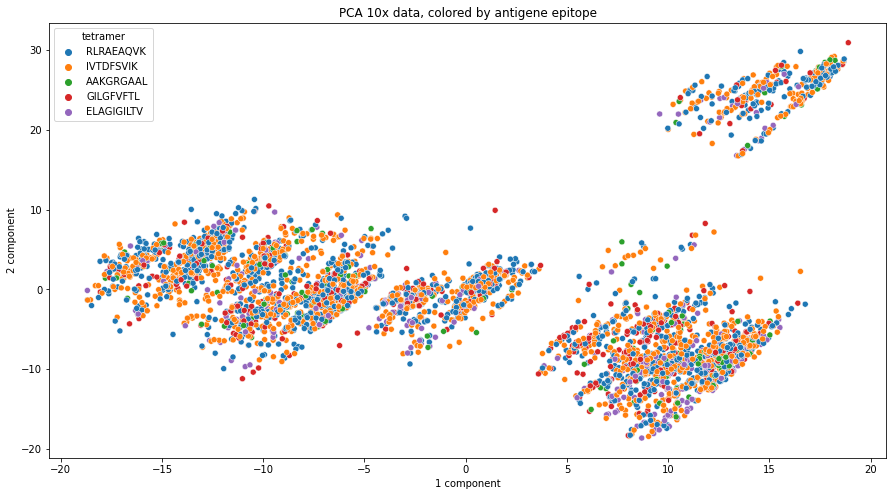

In [69]:
pc1 = 1
pc2 = 2
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data[pca_df_data['tetramer'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [70]:
X_embedded = tsne(pca_df,2,0,10)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])

In [71]:

tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

In [72]:
tsne_df_data

,DM1,DM2,barcode
0,-3.878536,-9.344246,AAACCTGAGACTGTAA-34
1,-92.124985,-32.303673,AAACCTGAGAGCCCAA-5
2,-69.429451,-28.769197,AAACCTGAGAGCTGCA-24
3,-9.137000,9.886559,AAACCTGAGAGGGATA-8
4,-2.261874,-0.085607,AAACCTGAGATCCTGT-25
...,...,...,...
21572,70.219849,-68.695251,TTTGTCATCGAGCCCA-39
21573,12.973147,13.455242,TTTGTCATCGAGGTAG-13
21574,-22.013153,-67.833832,TTTGTCATCTCCAACC-24
21575,-48.297276,22.548477,TTTGTCATCTCCTATA-36


In [73]:
tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer
0,AAACCTGAGACTGTAA-34,-3.878536,-9.344246,AVFDRKSDAK
1,AAACCTGAGAGCCCAA-5,-92.124985,-32.303673,CLLGTYTQDV
2,AAACCTGAGAGCTGCA-24,-69.429451,-28.769197,RAKFKQLL
3,AAACCTGAGAGGGATA-8,-9.137000,9.886559,RLRAEAQVK
4,AAACCTGAGATCCTGT-25,-2.261874,-0.085607,TPRVTGGGAM
...,...,...,...,...
21572,TTTGTCATCGAGCCCA-39,70.219849,-68.695251,AVFDRKSDAK
21573,TTTGTCATCGAGGTAG-13,12.973147,13.455242,GILGFVFTL
21574,TTTGTCATCTCCAACC-24,-22.013153,-67.833832,IVTDFSVIK
21575,TTTGTCATCTCCTATA-36,-48.297276,22.548477,AVFDRKSDAK


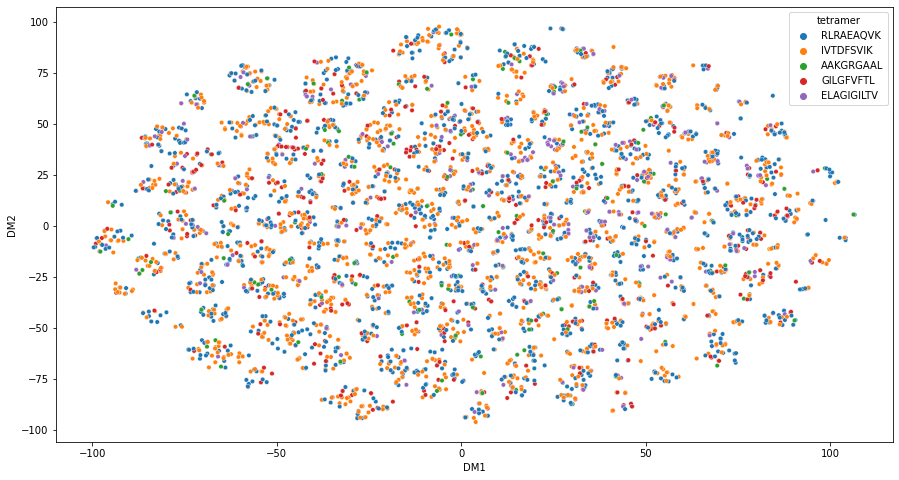

In [75]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

In [ ]:
##trying data from clustering using tetramers

In [25]:
v_param = '190123'
matrix_path = 'data_scripts/10x_tetramer_matrix' + v_param + '.txt'
matrix_t = pd.read_csv(matrix_path, sep='\t')

In [ ]:
matrix_t = matrix_t[['barcode','tetramer']].drop_duplicates().reset_index()

In [ ]:
#data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot_2 = data.copy()
data_c_annot_2 = data_c_annot_2[data_c_annot_2['is_cell']==True].reset_index(drop=True)
data_c_annot_2 = filter_table(data_c_annot_2,'TRB')
data_c_2 = data_c_annot_2.copy()
data_c_2 = merge_anot_matrix(data_c_2,barcode_tetramer)
data_c_2

In [163]:
#data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot_2 = prep_annot_data(data)
data_c_2 = data_c_annot_2[data_c_annot_2['high_confidence']==True]
data_c_2 = merge_anot_matrix(data_c_2,matrix_t)
data_c_2

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,index,tetramer
0,AAACCTGAGAGTGAGA-23,True,AAACCTGAGAGTGAGA-23_contig_1,True,661,TRB,TRBV15,TRBD1,TRBJ1-3,TRBC1,True,True,CATSRDRGHGDTIYF,TGTGCCACCAGCAGAGATCGGGGCCATGGGGACACCATATATTTT,17076,6,clonotype244,clonotype244_consensus_2,200570,KLGGALQAK
1,AAACCTGAGATTACCC-16,True,AAACCTGAGATTACCC-16_contig_2,True,659,TRB,TRBV28,None,TRBJ2-2,TRBC2,True,True,CASSLYSATGELFF,TGTGCCAGCAGTTTATACTCCGCCACCGGGGAGCTGTTTTTT,38086,10,clonotype2,clonotype2_consensus_3,34217,AVFDRKSDAK
2,AAACCTGAGGCTCATT-34,True,AAACCTGAGGCTCATT-34_contig_1,True,767,TRB,TRBV18,TRBD1,TRBJ2-6,TRBC2,True,True,CASSPGAPRSGANVLTF,TGTGCCAGCTCACCCGGGGCCCCCCGGTCTGGGGCCAACGTCCTGA...,23507,13,clonotype1330,clonotype1330_consensus_1,189517,KLGGALQAK
3,AAACCTGAGGGAGTAA-40,True,AAACCTGAGGGAGTAA-40_contig_2,True,691,TRB,TRBV11-2,TRBD1,TRBJ1-2,TRBC1,True,True,CASSWGGGSHYGYTF,TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC,12242,12,clonotype786,clonotype786_consensus_4,33081,IVTDFSVIK
4,AAACCTGAGGGAGTAA-40,True,AAACCTGAGGGAGTAA-40_contig_4,True,650,TRB,TRBV28,None,TRBJ2-2,TRBC2,True,True,CASSLYSATGELFF,TGTGCCAGCAGTTTATACTCCGCCACCGGGGAGCTGTTTTTT,7103,7,clonotype786,clonotype786_consensus_5,33081,IVTDFSVIK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21120,TTTGTCATCCGAAGAG-35,True,TTTGTCATCCGAAGAG-35_contig_2,True,566,TRB,TRBV20-1,TRBD1,TRBJ2-7,TRBC2,True,True,CSASPGDYEQYF,TGCAGTGCTAGTCCAGGGGACTACGAGCAGTACTTC,16012,8,clonotype5,clonotype5_consensus_1,109526,KLGGALQAK
21121,TTTGTCATCCTATGTT-26,True,TTTGTCATCCTATGTT-26_contig_2,True,539,TRB,TRBV12-3,None,TRBJ2-7,TRBC2,True,True,CASSLPGSYEQYF,TGTGCCAGCAGTTTGCCGGGGTCCTACGAGCAGTACTTC,16457,11,clonotype30334,clonotype30334_consensus_2,183871,KLGGALQAK
21122,TTTGTCATCGAGGTAG-13,True,TTTGTCATCGAGGTAG-13_contig_3,True,679,TRB,TRBV19,None,TRBJ1-5,TRBC1,True,True,CASSTSNEQPQHF,TGTGCCAGTAGTACGTCGAATGAACAGCCCCAGCATTTT,2415,2,clonotype30336,clonotype30336_consensus_2,102110,GILGFVFTL
21123,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1,146629,AVFDRKSDAK


In [164]:
data_c_2_mir = columns_prep(data_c_2)
data_c_2_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGAGTGAGA-23_contig_1,661,TRBV15,TRBJ1-3,CATSRDRGHGDTIYF,17076,6,1,-1,-1,-1,-1,-1,TGTGCTACTTCTCGTGATCGTGGTCATGGTGATACTATTTATTTT,.
1,AAACCTGAGATTACCC-16_contig_2,659,TRBV28,TRBJ2-2,CASSLYSATGELFF,38086,10,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTATATTCTGCTACTGGTGAATTATTTTTT,.
2,AAACCTGAGGCTCATT-34_contig_1,767,TRBV18,TRBJ2-6,CASSPGAPRSGANVLTF,23507,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCCTGGTGCTCCTCGTTCTGGTGCTAATGTTTTAA...,.
3,AAACCTGAGGGAGTAA-40_contig_2,691,TRBV11-2,TRBJ1-2,CASSWGGGSHYGYTF,12242,12,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTGGGGTGGTGGTTCTCATTATGGTTATACTTTT,.
4,AAACCTGAGGGAGTAA-40_contig_4,650,TRBV28,TRBJ2-2,CASSLYSATGELFF,7103,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTATATTCTGCTACTGGTGAATTATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21120,TTTGTCATCCGAAGAG-35_contig_2,566,TRBV20-1,TRBJ2-7,CSASPGDYEQYF,16012,8,1,-1,-1,-1,-1,-1,TGTTCTGCTTCTCCTGGTGATTATGAACAATATTTT,.
21121,TTTGTCATCCTATGTT-26_contig_2,539,TRBV12-3,TRBJ2-7,CASSLPGSYEQYF,16457,11,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTACCTGGTTCTTATGAACAATATTTT,.
21122,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
21123,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [12]:
#temp file
file_date = '100522'
file_path = 'data/10x_trb_' + file_date +'.txt'
data_c_2_mir.to_csv(file_path, sep='\t', index = False)

In [13]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "/home/yuliajk/projects/tcr_emb_2022/data/prototypes_280322.txt"
input_data_path = 'data/10x_trb_' + file_date +'.txt'
output_path = "data_scripts/10x_trb_" + file_date + "_"

#command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
#os.system(command)




In [ ]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

In [42]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_2_mir = pd.read_csv(input_data_path, sep='\t')
data_c_2_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGAGTGAGA-23_contig_1,661,TRBV15,TRBJ1-3,CATSRDRGHGDTIYF,17076,6,1,-1,-1,-1,-1,-1,TGTGCTACTTCTCGTGATCGTGGTCATGGTGATACTATTTATTTT,.
1,AAACCTGAGATTACCC-16_contig_2,659,TRBV28,TRBJ2-2,CASSLYSATGELFF,38086,10,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTATATTCTGCTACTGGTGAATTATTTTTT,.
2,AAACCTGAGGCTCATT-34_contig_1,767,TRBV18,TRBJ2-6,CASSPGAPRSGANVLTF,23507,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCCTGGTGCTCCTCGTTCTGGTGCTAATGTTTTAA...,.
3,AAACCTGAGGGAGTAA-40_contig_2,691,TRBV11-2,TRBJ1-2,CASSWGGGSHYGYTF,12242,12,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTGGGGTGGTGGTTCTCATTATGGTTATACTTTT,.
4,AAACCTGAGGGAGTAA-40_contig_4,650,TRBV28,TRBJ2-2,CASSLYSATGELFF,7103,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTATATTCTGCTACTGGTGAATTATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21115,TTTGTCATCCGAAGAG-35_contig_2,566,TRBV20-1,TRBJ2-7,CSASPGDYEQYF,16012,8,1,-1,-1,-1,-1,-1,TGTTCTGCTTCTCCTGGTGATTATGAACAATATTTT,.
21116,TTTGTCATCCTATGTT-26_contig_2,539,TRBV12-3,TRBJ2-7,CASSLPGSYEQYF,16457,11,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTACCTGGTTCTTATGAACAATATTTT,.
21117,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
21118,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [43]:
data_c_2_mir.iloc[12313]

contig_id      GATGAAAAGTAGCCGA-29_contig_3
length                                  403
v                                   TRBV6-3
j                                      None
cdr3aa                           CTGIDKTQAW
reads                                  1479
umis                                      1
count                                     1
DStart                                   -1
DEnd                                     -1
VEnd                                     -1
JStart                                   -1
freq                                     -1
cdr3nt       TGTACTGGTATTGATAAAACTCAAGCTTGG
subset                                    .
Name: 12314, dtype: object

In [16]:
data_c_2_mir.iloc[12315]

contig_id                     GATGAAAAGTACGCGA-14_contig_1
length                                                 901
v                                                   TRBV19
j                                                  TRBJ2-1
cdr3aa                                     CASSPLAVTYNEQFF
reads                                                12263
umis                                                    11
count                                                    1
DStart                                                  -1
DEnd                                                    -1
VEnd                                                    -1
JStart                                                  -1
freq                                                    -1
cdr3nt       TGTGCTTCTTCTCCTTTAGCTGTTACTTATAATGAACAATTTTTT
subset                                                   .
Name: 12315, dtype: object

In [44]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,106.0,32.0,24.0
1,1,2,181.0,33.0,14.0
2,1,3,149.0,33.0,20.0
3,1,4,145.0,32.0,23.0
4,1,5,75.0,35.0,20.0
...,...,...,...,...,...
3693739,12313,140,261.0,41.0,13.0
3693740,12313,141,164.0,60.0,33.0
3693741,12313,142,77.0,62.0,11.0
3693742,12313,143,164.0,49.0,19.0


In [15]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1.0,106.0,32.0,24.0
1,1,2.0,181.0,33.0,14.0
2,1,3.0,149.0,33.0,20.0
3,1,4.0,145.0,32.0,23.0
4,1,5.0,75.0,35.0,20.0
...,...,...,...,...,...
3694382,12315,183.0,117.0,44.0,9.0
3694383,12315,184.0,173.0,43.0,18.0
3694384,12315,185.0,148.0,41.0,13.0
3694385,12315,186.0,158.0,37.0,8.0


In [191]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id1',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id1',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c_2['barcode'],drop = True)

ValueError: Length mismatch: Expected 12315 rows, received array of length 21125

In [ ]:
pca_df, pca_model = pca(data_c_b_dist,300)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index

In [ ]:
pca_df_data=pca_df_data.merge(data_c_2[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 component')

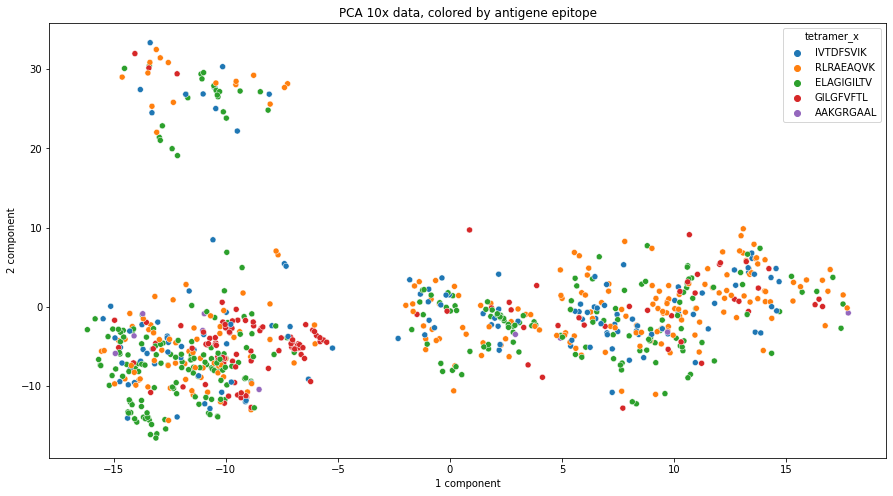

In [131]:
pc1 = 1
pc2 = 2
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data[pca_df_data['tetramer'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [132]:
X_embedded = tsne(pca_df,2,0,10)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])

In [133]:

tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

In [134]:
tsne_df_data=tsne_df_data.merge(data_c_2[['barcode','tetramer']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer_x
0,AAACCTGAGGCTCATT-34,97.827011,20.881618,KLGGALQAK
1,AAACCTGAGTCTCGGC-10,-25.569902,57.701054,KLGGALQAK
2,AAACCTGCACAGACAG-30,38.581619,-55.092007,IVTDFSVIK
3,AAACCTGCAGTCAGAG-28,-6.213584,-67.888481,KLGGALQAK
4,AAACGGGAGCTCTCGG-39,37.291496,3.303477,KLGGALQAK
...,...,...,...,...
4788,TTTGTCAGTGGCGAAT-31,16.191666,41.034538,KLGGALQAK
4789,TTTGTCATCAGGTAAA-40,76.354736,19.434790,AAKGRGAAL
4790,TTTGTCATCCTATGTT-26,-47.646870,46.115395,KLGGALQAK
4791,TTTGTCATCGAGGTAG-13,20.466644,-32.545189,GILGFVFTL


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


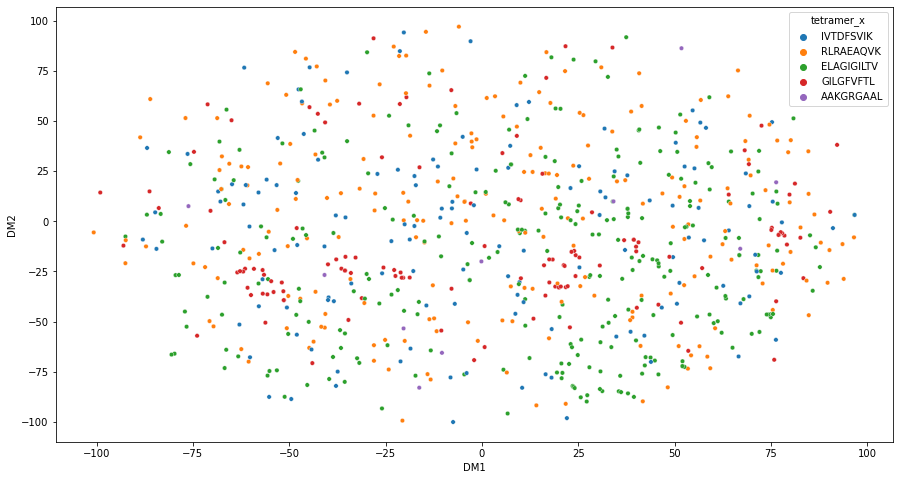

In [135]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

## old

In [ ]:
barcodes = pd.read_csv('/home/yuliajk/projects/tcr_emb_2022_2/data/exploring_immunity/filtered_feature_bc_matrix/barcodes.tsv', sep = '\t',header = None)
barcodes.columns = ['barcode']
barcodes.index += 1
barcodes['barcode_id'] = barcodes.index
barcodes

In [ ]:
features = pd.read_csv('/home/yuliajk/projects/tcr_emb_2022_2/data/exploring_immunity/filtered_feature_bc_matrix/features.tsv', sep = '\t',header = None)
features.index += 1
features.columns = ['feature_code','value','type']
features['feature_id'] = features.index
features['feature_id'] = pd.to_numeric(features['feature_id'])
features

In [4]:
matrix = pd.read_csv('/home/yuliajk/projects/tcr_emb_2022_2/data/exploring_immunity/filtered_feature_bc_matrix/matrix.mtx',sep = '\t')
matrix = matrix.drop([0])
matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
matrix = matrix.apply(pd.to_numeric)
matrix


,feature_id,barcode_id,count
1,33602,55206,76112470
2,44,1,2
3,54,1,1
4,55,1,1
5,67,1,1
...,...,...,...
76112467,33552,55206,7
76112468,33569,55206,1
76112469,33582,55206,1
76112470,33589,55206,2


In [5]:
matrix = pd.merge(matrix, barcodes, on="barcode_id")
matrix = pd.merge(matrix, features, on="feature_id")
matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
matrix

,count,barcode,feature_code,value,type
0,76112470,TTTGTCATCAGGTAAA-40,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
1,1,AACACGTTCCGCGCAA-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
2,1,AACGTTGGTTTGGCGC-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
3,1,AACGTTGTCGGATGTT-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
4,4,AAGGTTCCATTAGGCT-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
...,...,...,...,...,...
76112466,1,TTTATGCCATGTCTCC-40,ENSG00000185662,SMIM23,Gene Expression
76112467,1,TTTCCTCAGAAGGTGA-40,ENSG00000236389,AL121970.1,Gene Expression
76112468,1,TTTGCGCCAGTCAGAG-40,ENSG00000158246,TENT5B,Gene Expression
76112469,1,TTTGCGCCAGTCAGAG-40,ENSG00000158163,DZIP1L,Gene Expression


In [6]:
matrix = matrix[matrix['type']=='Antibody Capture']
matrix

,count,barcode,feature_code,value,type
0,76112470,TTTGTCATCAGGTAAA-40,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
1,1,AACACGTTCCGCGCAA-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
2,1,AACGTTGGTTTGGCGC-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
3,1,AACGTTGTCGGATGTT-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
4,4,AAGGTTCCATTAGGCT-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL_NC,Antibody Capture
...,...,...,...,...,...
76081072,1,ACGCCGAGTTCCAACA-35,CD127,CD127_TotalSeqC,Antibody Capture
76081073,1,CGATCGGCAATAACGA-35,CD127,CD127_TotalSeqC,Antibody Capture
76081074,1,AGGGAGTAGATGTGGC-39,CD127,CD127_TotalSeqC,Antibody Capture
76081075,1,CGTTAGACACGAAGCA-39,CD127,CD127_TotalSeqC,Antibody Capture


In [7]:
v_t = matrix['value'].str.split('_',n=1,expand=True)
matrix['value']=v_t[0]
matrix['value_type']=v_t[1]
matrix

/home/yuliajk/.conda-envs/python3/bin/ipython:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yuliajk/.conda-envs/python3/bin/ipython:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # -*- coding: utf-8 -*-


,count,barcode,feature_code,value,type,value_type
0,76112470,TTTGTCATCAGGTAAA-40,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL,Antibody Capture,NC
1,1,AACACGTTCCGCGCAA-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL,Antibody Capture,NC
2,1,AACGTTGGTTTGGCGC-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL,Antibody Capture,NC
3,1,AACGTTGTCGGATGTT-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL,Antibody Capture,NC
4,4,AAGGTTCCATTAGGCT-1,NR(B0801)_AAKGRGAAL_NC,AAKGRGAAL,Antibody Capture,NC
...,...,...,...,...,...,...
76081072,1,ACGCCGAGTTCCAACA-35,CD127,CD127,Antibody Capture,TotalSeqC
76081073,1,CGATCGGCAATAACGA-35,CD127,CD127,Antibody Capture,TotalSeqC
76081074,1,AGGGAGTAGATGTGGC-39,CD127,CD127,Antibody Capture,TotalSeqC
76081075,1,CGTTAGACACGAAGCA-39,CD127,CD127,Antibody Capture,TotalSeqC


In [8]:
matrix = matrix[matrix['value_type']!='TotalSeqC']

In [145]:
data = pd.read_csv("/home/yuliajk/projects/tcr_emb_2022_2/data/exploring_immunity/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')

data

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1
1,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_2,True,605,TRA,TRAV29DV5,None,TRAJ44,TRAC,True,True,CAASVSIWTGTASKLTF,TGTGCAGCAAGCGTTAGTATTTGGACCGGCACTGCCAGTAAACTCA...,6088,3,clonotype19,clonotype19_consensus_2
2,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_3,True,738,TRA,TRAV8-6,None,TRAJ47,TRAC,True,True,CAAWDMEYGNKLVF,TGTGCCGCCTGGGACATGGAATATGGAAACAAGCTGGTCTTT,5358,3,clonotype19,clonotype19_consensus_3
3,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_4,False,468,TRB,None,None,TRBJ2-3,TRBC2,False,None,None,None,2517,1,clonotype19,None
4,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_5,False,488,TRB,None,None,TRBJ2-6,TRBC2,False,None,None,None,2468,1,clonotype19,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187139,TTTGTCATCCCAGGTG-3,False,TTTGTCATCCCAGGTG-3_contig_2,False,508,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSPGGLAGADTQYF,TGCGCCAGCAGCCCGGGGGGACTAGCGGGGGCAGATACGCAGTATTTT,2494,1,None,None
187140,TTTGTCATCTGCAAGT-21,False,TTTGTCATCTGCAAGT-21_contig_1,True,546,TRA,TRAV12-2,None,TRAJ21,TRAC,True,True,CAVEGGFNKFYF,TGTGCCGTGGAAGGGGGATTCAACAAATTTTACTTT,8373,3,None,None
187141,TTTGTCATCTTACCGC-24,False,TTTGTCATCTTACCGC-24_contig_1,True,575,TRA,TRAV38-1,None,TRAJ30,TRAC,True,True,CAFSLNRDDKIIF,TGTGCTTTCTCCCTGAACAGAGATGACAAGATCATCTTT,2590,1,None,None
187142,TTTGTCATCTTACCGC-24,False,TTTGTCATCTTACCGC-24_contig_2,False,549,TRA,TRAV12-1,None,TRAJ43,TRAC,True,True,CVVDDMRF,TGTGTGGTGGATGACATGCGCTTT,1367,1,None,None


In [151]:
data_c = data[data['is_cell']==True].reset_index(drop=True)
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1
1,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_2,True,605,TRA,TRAV29DV5,None,TRAJ44,TRAC,True,True,CAASVSIWTGTASKLTF,TGTGCAGCAAGCGTTAGTATTTGGACCGGCACTGCCAGTAAACTCA...,6088,3,clonotype19,clonotype19_consensus_2
2,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_3,True,738,TRA,TRAV8-6,None,TRAJ47,TRAC,True,True,CAAWDMEYGNKLVF,TGTGCCGCCTGGGACATGGAATATGGAAACAAGCTGGTCTTT,5358,3,clonotype19,clonotype19_consensus_3
3,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_4,False,468,TRB,None,None,TRBJ2-3,TRBC2,False,None,None,None,2517,1,clonotype19,None
4,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_5,False,488,TRB,None,None,TRBJ2-6,TRBC2,False,None,None,None,2468,1,clonotype19,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173267,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_2,True,331,Multi,None,None,TRBJ2-3,TRBC2,False,None,None,None,450,1,clonotype74,None
173268,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_3,True,539,TRA,TRAV19,None,TRAJ26,TRAC,True,True,CALSEARNYGQNFVF,TGTGCTCTGAGTGAGGCGCGAAACTATGGTCAGAATTTTGTCTTT,2228,1,clonotype74,clonotype74_consensus_1
173269,TTTGTCATCTGTCCGT-39,True,TTTGTCATCTGTCCGT-39_contig_1,True,955,TRB,TRBV23-1,TRBD2,TRBJ1-1,TRBC1,True,True,CISAPAVPPAGKAFF,TGTATCTCTGCGCCAGCAGTTCCCCCGGCCGGGAAAGCTTTCTTT,3915,4,clonotype30340,clonotype30340_consensus_2
173270,TTTGTCATCTGTCCGT-39,True,TTTGTCATCTGTCCGT-39_contig_2,True,794,TRB,TRBV23-1,TRBD2,TRBJ1-1,TRBC1,True,None,None,None,2127,4,clonotype30340,None


In [155]:
data_c = pd.merge(data_c,matrix, on='barcode')

In [156]:
data_c = data_c[data_c['count']>4]
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,count,feature_code,value,type,value_type
14,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,...,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1,5,A1101_AVFDRKSDAK_EBNA-3B_EBV,AVFDRKSDAK,Antibody Capture,EBNA-3B_EBV
17,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_2,False,447,TRB,None,None,TRBJ2-1,TRBC2,...,None,2711,1,clonotype1318,None,5,A1101_AVFDRKSDAK_EBNA-3B_EBV,AVFDRKSDAK,Antibody Capture,EBNA-3B_EBV
20,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_3,False,452,TRB,None,None,TRBJ2-3,TRBC2,...,None,1486,1,clonotype1318,None,5,A1101_AVFDRKSDAK_EBNA-3B_EBV,AVFDRKSDAK,Antibody Capture,EBNA-3B_EBV
57,AAACCTGAGAGTGAGA-23,True,AAACCTGAGAGTGAGA-23_contig_1,True,661,TRB,TRBV15,TRBD1,TRBJ1-3,TRBC1,...,TGTGCCACCAGCAGAGATCGGGGCCATGGGGACACCATATATTTT,17076,6,clonotype244,clonotype244_consensus_2,6,A0301_KLGGALQAK_IE-1_CMV,KLGGALQAK,Antibody Capture,IE-1_CMV
60,AAACCTGAGAGTGAGA-23,True,AAACCTGAGAGTGAGA-23_contig_2,True,584,TRA,TRAV29DV5,None,TRAJ48,TRAC,...,TGTGCAGCACACTTATCTAACTTTGGAAATGAGAAATTAACCTTT,15672,4,clonotype244,clonotype244_consensus_1,6,A0301_KLGGALQAK_IE-1_CMV,KLGGALQAK,Antibody Capture,IE-1_CMV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951799,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_2,True,331,Multi,None,None,TRBJ2-3,TRBC2,...,None,450,1,clonotype74,None,16,A1101_AVFDRKSDAK_EBNA-3B_EBV,AVFDRKSDAK,Antibody Capture,EBNA-3B_EBV
951802,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_3,True,539,TRA,TRAV19,None,TRAJ26,TRAC,...,TGTGCTCTGAGTGAGGCGCGAAACTATGGTCAGAATTTTGTCTTT,2228,1,clonotype74,clonotype74_consensus_1,28,A0301_KLGGALQAK_IE-1_CMV,KLGGALQAK,Antibody Capture,IE-1_CMV
951804,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_3,True,539,TRA,TRAV19,None,TRAJ26,TRAC,...,TGTGCTCTGAGTGAGGCGCGAAACTATGGTCAGAATTTTGTCTTT,2228,1,clonotype74,clonotype74_consensus_1,15,A0301_RLRAEAQVK_EMNA-3A_EBV,RLRAEAQVK,Antibody Capture,EMNA-3A_EBV
951806,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_3,True,539,TRA,TRAV19,None,TRAJ26,TRAC,...,TGTGCTCTGAGTGAGGCGCGAAACTATGGTCAGAATTTTGTCTTT,2228,1,clonotype74,clonotype74_consensus_1,9,A1101_IVTDFSVIK_EBNA-3B_EBV,IVTDFSVIK,Antibody Capture,EBNA-3B_EBV


In [ ]:
data_c
69631 : cdr3 == None
8259 unique cdr3
1749 cdr3 contain *


### Table prep for MIR

In [157]:
def aminoacid_to_nt(cdr3):
    gene_code = {"A":"GCT", "C":"TGT", "T":"ACT", "S":"TCT", "F": "TTT", "L":"TTA", "I":"ATT", 
                 "M":"ATG", "V":"GTT", "P":"CCT", "Y":"TAT", "H":"CAT","Q": "CAA", "N":"AAT", 
                 "K":"AAA", "D":"GAT", "E":"GAA", "W":"TGG", "R":"CGT", "G":"GGT"}
    res = ''.join([gene_code.get(i) for i in list(cdr3)])
    return res

In [158]:

def table_prep(data,chain):
    if chain== "TRA":
        data = data[data['chain'] == "TRA"]
    
    if chain== "TRB":
        data = data[data['chain'] == "TRB"]
    
    #cols_input = list(data.columns)
    data = data[-data['v_gene'].isna()]
    data = data[-data['j_gene'].isna()]
    data = data[-(data['v_gene']== "None")]
    data = data[-(data['j_gene']== "None")]
    data = data[-(data['j_gene']== "")]
    data = data[-(data['v_gene']== "")]
    data = data[-data['v_gene'].str.contains(',')]
    data = data[-data['j_gene'].str.contains(',')]

    data = data[-(data['cdr3']== "")]
    data = data[-(data['cdr3']== "None")]
    data = data[-data['cdr3'].isna()]
    data = data[-data['cdr3'].str.contains('\.')]
    data = data[-data['cdr3'].str.contains('\*')]

    data = data.assign(d_gene = ".")
    data = data.assign(count = 1)
    data['DStart'] =  -1
    data['DEnd'] =  -1
    data['VEnd'] =  -1
    data['JStart'] =  -1
    data['freq'] =  -1
    data['cdr3nt'] = data['cdr3'].apply(lambda x: aminoacid_to_nt(x))
    
    data = data.rename(columns={"cdr3": "cdr3aa"})
    data = data.rename(columns={"v_gene": "v"})
    data = data.rename(columns={"j_gene": "j"})
    data = data.assign(subset = ".")
    #data = data.rename(columns={"value": "subset"})
    #data = data.rename(columns={"cdr3_nt": "cdr3nt"})

    cols = ["count", "freq", "cdr3aa", "cdr3nt", "v", "d", "j", "VEnd", "DStart", "DEnd","JStart","contig_id","reads","umis","length","subset"]
    data.drop(set(data.columns) - set(cols), axis=1, inplace=True)
    data = data.drop_duplicates(subset = ['cdr3aa'], keep = False)
    data = data.reset_index(drop=True)
    return data

In [159]:
data_c_mir = table_prep(data_c,'TRB')
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
1,AAACCTGCAAGGGTCA-40_contig_5,707,TRBV6-1,TRBJ2-7,CASSVGGAYEQYF,1876,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGTTGGTGGTGCTTATGAACAATATTTT,.
2,AAACCTGCACAGACAG-30_contig_1,605,TRBV6-3,TRBJ2-2,CASSYQTRDYRPLTGELFF,9958,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTATCAAACTCGTGATTATCGTCCTTTAACTGGTG...,.
3,AAACCTGCATTTGCTT-39_contig_2,654,TRBV5-1,TRBJ2-7,CASSLRRGYEQYF,3205,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTACGTCGTGGTTATGAACAATATTTT,.
4,AAACCTGGTAGCCTAT-40_contig_1,852,TRBV9,TRBJ2-7,CASSSGSYEQYF,10170,8,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGGTTCTTATGAACAATATTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,TTTGTCACATTTCAGG-15_contig_1,667,TRBV25-1,TRBJ2-7,CASSDPKGAYEQYF,19544,10,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGATCCTAAAGGTGCTTATGAACAATATTTT,.
4122,TTTGTCAGTGGCGAAT-31_contig_2,480,TRBV5-6,TRBJ1-1,CASSSGRSTEAFF,1999,1,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGGTCGTTCTACTGAAGCTTTTTTT,.
4123,TTTGTCATCAGGTAAA-40_contig_2,504,TRBV9,TRBJ1-2,CASSPHPTGGRGYTF,3867,4,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCCTCATCCTACTGGTGGTCGTGGTTATACTTTT,.
4124,TTTGTCATCCGTTGTC-38_contig_1,724,TRBV20-1,TRBJ2-1,CSAREGLAGGSYNEQFF,30845,15,1,-1,-1,-1,-1,-1,TGTTCTGCTCGTGAAGGTTTAGCTGGTGGTTCTTATAATGAACAAT...,.


In [160]:
#temp file
data_c_mir.to_csv('data/10x_trb_060123.txt', sep='\t', index = False)

In [161]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "/home/yuliajk/projects/tcr_emb_2022/data/prototypes_280322.txt"
input_data_path = 'data/10x_trb_060123.txt'
output_path = "data/10x_trb_060123_"

#command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
#os.system(command)




In [162]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

0

In [163]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_mir = pd.read_csv(input_data_path, sep='\t')

In [168]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,124.0,54.0,15.0
1,1,2,178.0,41.0,10.0
2,1,3,154.0,45.0,5.0
3,1,4,209.0,54.0,19.0
4,1,5,87.0,85.0,18.0
...,...,...,...,...,...
1237795,4126,296,130.0,81.0,40.0
1237796,4126,297,89.0,81.0,41.0
1237797,4126,298,166.0,81.0,49.0
1237798,4126,299,72.0,81.0,22.0


In [169]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id1',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id1',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c_mir['cdr3aa'],drop = True)

In [170]:
data_c_b_dist

,cdr3_1,cdr3_10,cdr3_100,cdr3_101,cdr3_102,cdr3_103,cdr3_104,cdr3_105,cdr3_106,cdr3_107,...,j_90,j_91,j_92,j_93,j_94,j_95,j_96,j_97,j_98,j_99
cdr3aa,,,,,,,,,,,,,,,,,,,,,
CASDTPVGQFF,15.0,10.0,22.0,13.0,26.0,8.0,13.0,11.0,20.0,19.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0
CASSVGGAYEQYF,28.0,20.0,26.0,20.0,46.0,18.0,33.0,21.0,20.0,48.0,...,43.0,54.0,43.0,60.0,43.0,35.0,54.0,60.0,81.0,42.0
CASSYQTRDYRPLTGELFF,-5.0,1.0,6.0,20.0,29.0,5.0,21.0,9.0,32.0,10.0,...,38.0,37.0,38.0,45.0,38.0,44.0,37.0,45.0,42.0,38.0
CASSLRRGYEQYF,14.0,21.0,31.0,15.0,37.0,20.0,44.0,21.0,23.0,32.0,...,43.0,54.0,43.0,60.0,43.0,35.0,54.0,60.0,81.0,42.0
CASSSGSYEQYF,19.0,20.0,20.0,16.0,33.0,15.0,25.0,20.0,21.0,32.0,...,43.0,54.0,43.0,60.0,43.0,35.0,54.0,60.0,81.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASSDPKGAYEQYF,26.0,13.0,21.0,18.0,40.0,17.0,26.0,16.0,18.0,31.0,...,43.0,54.0,43.0,60.0,43.0,35.0,54.0,60.0,81.0,42.0
CASSSGRSTEAFF,11.0,15.0,18.0,27.0,30.0,8.0,19.0,15.0,29.0,28.0,...,45.0,38.0,45.0,44.0,45.0,45.0,38.0,44.0,47.0,39.0
CASSPHPTGGRGYTF,9.0,5.0,4.0,14.0,16.0,6.0,11.0,16.0,6.0,9.0,...,80.0,35.0,80.0,41.0,80.0,38.0,35.0,41.0,43.0,37.0


## PCA

In [171]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

In [206]:
pca_df, pca_model = pca(data_c_b_dist,300)
pca_df_data = pca_df.copy()
pca_df_data['cdr3']=data_c_b_dist.index

In [207]:
pca_df_data

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,cdr3
0,-3.898287,7.093132,7.217743,-2.509176,-3.193953,-4.408476,7.497246,12.723614,1.555966,-2.930778,...,-0.012554,0.088346,0.165593,0.191439,-0.206745,-0.113818,0.077141,-0.222833,-0.134620,CASDTPVGQFF
1,-16.355872,-12.705783,-4.457326,-10.213992,3.634298,5.663073,3.853984,-7.388020,-3.046664,1.320403,...,0.190805,0.069265,-0.076259,-0.091238,0.019195,0.116059,-0.032335,-0.144763,0.115204,CASSVGGAYEQYF
2,17.161328,-10.994414,-4.738295,-1.984732,-9.737945,-5.873975,4.867938,0.677212,-5.393703,-1.922579,...,-0.144954,0.036892,-0.064823,-0.209534,0.068132,-0.182666,-0.053106,0.263370,-0.407299,CASSYQTRDYRPLTGELFF
3,-16.912282,7.201225,-3.303860,-10.131033,4.015567,8.841647,-8.754354,1.750560,-9.663112,7.359654,...,-0.033382,-0.068740,0.107652,0.126646,-0.022529,-0.139824,0.022449,0.029019,-0.223985,CASSLRRGYEQYF
4,-16.598894,5.532504,-0.731631,-8.901447,3.687898,8.080453,-7.385118,0.357428,-7.078240,2.855665,...,0.076977,-0.058028,0.057146,-0.247122,0.001287,0.020096,-0.141429,-0.011105,-0.033176,CASSSGSYEQYF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,-14.697412,-12.627731,-3.027764,-9.478719,3.763662,6.200929,-0.810834,-3.143427,-2.405107,-3.210824,...,0.030354,0.156241,0.010707,-0.037693,0.126122,0.119753,0.126160,-0.252069,0.013606,CASSDPKGAYEQYF
4122,5.939724,10.080181,-4.187709,-3.573152,-8.392398,1.659749,-9.502818,-1.458081,-6.686982,5.010965,...,0.141007,-0.126858,0.179860,0.084163,0.136653,0.085696,0.167460,0.062004,0.120829,CASSSGRSTEAFF
4123,22.870978,10.737096,-3.606017,-8.940876,10.820217,-1.636623,-8.468010,2.937100,2.328020,7.142327,...,-0.118499,-0.205668,-0.027526,0.181867,-0.228694,0.095968,-0.221207,0.337838,-0.230851,CASSPHPTGGRGYTF
4124,-6.592747,-12.095927,30.786110,1.758242,-8.426718,0.415050,-2.401844,-1.533489,9.106491,7.085190,...,0.075361,-0.000541,-0.037073,0.039896,-0.063039,-0.107716,0.117903,-0.137629,0.022579,CSAREGLAGGSYNEQFF


In [208]:
pca_df_data=pca_df_data.merge(data_c[['cdr3','value']], on='cdr3')
pca_df_data= pca_df_data.groupby(['cdr3']).first().reset_index()
pca_df_data

,cdr3,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,value
0,CAAAGEADTQYF,-11.160803,-11.033855,-1.496475,6.160005,6.992890,-9.914853,4.743307,4.237584,-2.565810,...,-0.074672,0.226661,-0.119837,-0.084522,-0.025999,-0.063916,-0.077544,0.092632,0.086501,KLGGALQAK
1,CAAEGGGPLTDTQYF,-13.986913,12.888818,4.109180,10.318384,6.816394,-9.145062,6.645348,3.613068,-2.080276,...,-0.149385,0.097573,-0.229192,-0.024829,0.020060,0.086596,0.129607,-0.084064,0.158411,KLGGALQAK
2,CAAQNGNPNEKLFF,19.093846,-10.263138,-4.922892,6.498760,-10.038482,-3.326813,4.949195,-1.904873,-3.252309,...,-0.084054,-0.072599,-0.062916,0.345938,0.164151,-0.074526,-0.023684,-0.202182,0.072731,AVFDRKSDAK
3,CAARGLLGTDPYNEQFF,-6.634942,-13.097627,2.693906,-5.606151,-9.505954,-4.864075,8.169382,9.360169,2.482017,...,0.081584,0.031122,0.157135,0.045041,0.423735,0.014214,0.089560,0.182828,0.345515,KLGGALQAK
4,CAASGRASETQYF,-11.508249,-10.179220,-4.567536,8.874949,6.814591,-6.331745,-1.313231,-3.004436,-3.970457,...,-0.178813,0.020761,-0.043887,-0.049436,0.068528,0.075307,0.155312,0.101636,-0.093771,GILGFVFTL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,CTSVPSVSEGLFLDTQYF,-6.672181,-10.961512,0.817102,6.611681,5.378219,-11.898016,6.750381,11.594421,-4.320991,...,0.152240,0.272360,0.277984,0.153445,0.169176,-0.176359,-0.165889,0.003831,0.249814,RLRAEAQVK
4122,CVFLRQMTGEVSYEQYF,-3.436689,-10.826968,4.342142,-8.742350,3.129315,1.299357,8.046771,11.306538,-9.543949,...,-0.159083,-0.060667,-0.238199,-0.025596,0.565510,0.116852,-0.101894,-0.411534,-0.450166,KLGGALQAK
4123,CVPTGVHLGNTIYF,23.493775,15.886419,5.939190,6.963635,-1.457083,-8.811604,6.370998,-0.709066,-12.293663,...,0.137297,-0.022777,0.049477,0.178720,0.192094,-0.033834,-0.059476,-0.230192,-0.030795,GILGFVFTL
4124,CVSSLTAAEWTQYF,-11.734830,10.220228,3.314147,6.686307,7.377207,-6.398779,4.513288,6.434952,-2.727908,...,-0.142593,0.086226,-0.079909,0.041823,0.013028,0.091036,-0.016584,0.235738,-0.085249,KLGGALQAK


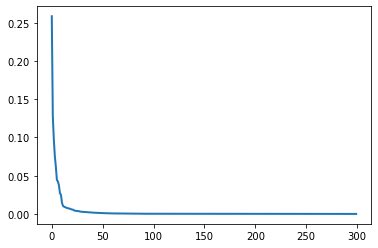

In [209]:
plt.plot(pca_model.explained_variance_ratio_, linewidth=2)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '12 component')

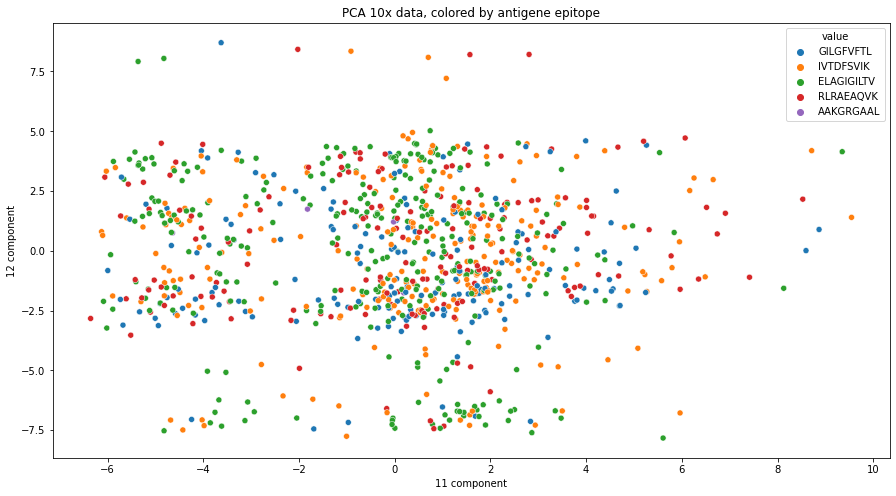

In [228]:
pc1 = 11
pc2 = 12
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data[tsne_df_data['value'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='value')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

## TSNE

In [210]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

In [211]:
X_embedded = tsne(pca_df,2,0,10)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


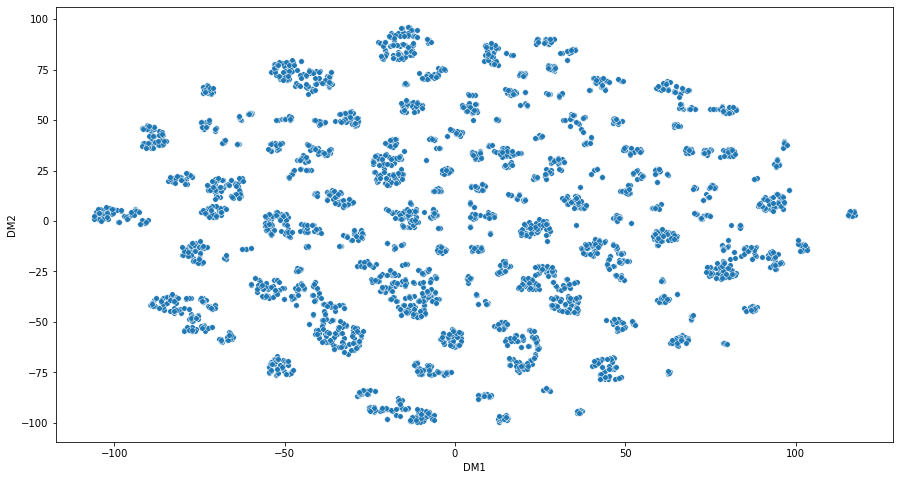

In [214]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=30)

In [215]:

tsne_df_data = tsne_df.copy()
tsne_df_data['cdr3']=data_c_b_dist.index

In [216]:
tsne_df_data=tsne_df_data.merge(data_c[['cdr3','value']], on='cdr3')
tsne_df_data= tsne_df_data.groupby(['cdr3']).first().reset_index()
tsne_df_data

,cdr3,DM1,DM2,value
0,CAAAGEADTQYF,-74.136139,-40.035576,KLGGALQAK
1,CAAEGGGPLTDTQYF,-89.397293,43.793110,KLGGALQAK
2,CAAQNGNPNEKLFF,62.650417,-5.436818,AVFDRKSDAK
3,CAARGLLGTDPYNEQFF,-4.803562,-38.603058,KLGGALQAK
4,CAASGRASETQYF,-16.689365,-88.964943,GILGFVFTL
...,...,...,...,...
4121,CTSVPSVSEGLFLDTQYF,-74.675201,-37.977726,RLRAEAQVK
4122,CVFLRQMTGEVSYEQYF,-34.108059,-41.647488,KLGGALQAK
4123,CVPTGVHLGNTIYF,32.199749,49.982128,GILGFVFTL
4124,CVSSLTAAEWTQYF,-72.139488,50.065868,KLGGALQAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


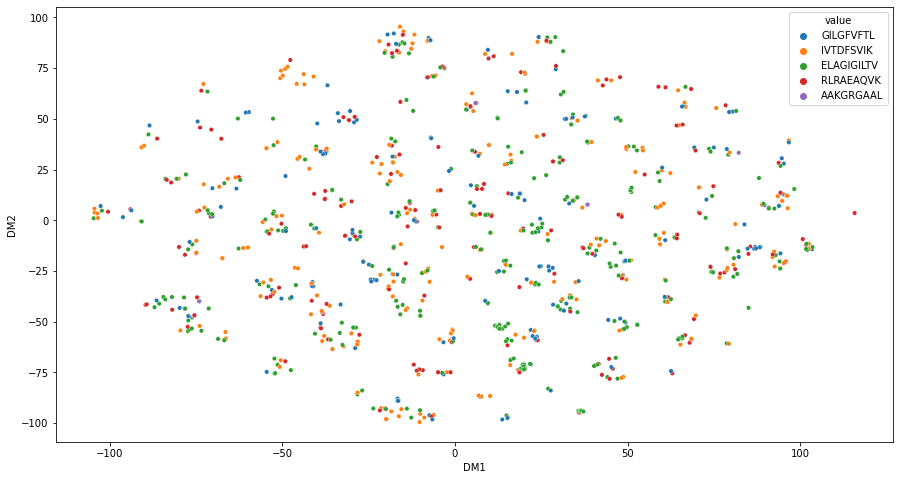

In [217]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['value'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='value',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

## Clustering

In [ ]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_,kmeans.n_clusters]
    
    results += [kmeans.n_init]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [ ]:
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']

n_start = 4
n_end = n_tetra

print(82 * "_")
print("init\tn_init\t\ttime\tinertia\tn_clust\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

n_init_param = 4
random_state_param = 0

init_param = "k-means++"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

init_param = "random"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

n_init_param = 20
random_state_param = 0

init_param = "k-means++"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

init_param = "random"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)
print(82 * "_")